In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import torch
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb
df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev) 

2.1.2+cu121
True
NVIDIA A10


In [3]:
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

In [4]:
obs.size()

torch.Size([1, 501])

In [5]:
#### Number of data points
#S = 500

# time inteval
delta = 1

#n = int(S/delta)
n = 500
y0 = 0
# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

501


In [6]:
# Data import
# Default : cuda
torch.set_default_device(device)

sim = [0, 1]

X_raw = []
output_raw = []
for j in [0, 1]:
    sim_path = "Comparison_sim/Comparison_sim" + str(j) +".pt"
    [tmp_X, tmp_y] = torch.load(sim_path)
    X_raw.append(tmp_X)
    output_raw.append(tmp_y)

X_raw = torch.cat(X_raw, dim = 0)
output_raw = torch.cat(output_raw, dim = 0)

X_raw = X_raw.to(device)
output_raw = output_raw.to(device)

X_raw = X_raw.to("cpu")

a = torch.quantile(X_raw, .001, 0)
a = torch.reshape(a, (1, a.size()[0]))
b = torch.quantile(X_raw, .999, 0)
b = torch.reshape(b, (1, b.size()[0]))

output = []
output.append(output_raw[:,0])
output.append(output_raw[:,1])
output.append(torch.log(output_raw[:,2]))
output.append(torch.log(output_raw[:,3]))
output = torch.column_stack(output)


X = torch.clone((X_raw - a) / (b - a))
torch.set_default_device(dev)
X = X.to(dev)
output = output.to(dev)

L = X.size()[0]
Lval = 40000
Ltest = 10000

X_train = X[range(0,L-Lval-Ltest),:]
y_train = output[range(0,L-Lval-Ltest),:]

X_val = X[range(L-Lval-Ltest,L-Ltest),:]
y_val = output[range(L-Lval-Ltest,L-Ltest),:]

X_test = X[range(L-Ltest,L),:]
y_test = output[range(L-Ltest,L),:]

print(X_train.size(), X_val.size(),X_test.size())

# Define the input and output dimensions
D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

# Create an instance of the Net class with specified dimensions
torch.manual_seed(2725)

# import net
net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)
model_save_name = 'Compare_MOUJ2.pt'
path = F"./{model_save_name}"

torch.Size([450000, 72]) torch.Size([40000, 72]) torch.Size([10000, 72])


In [7]:
for i in range(X.size()[1]):
    print(i, torch.max(X[:,i]), a[0,i], b[0,i])

0 tensor(1.0854, device='cuda:0') tensor(-2.0285) tensor(2.0820)
1 tensor(1.0859, device='cuda:0') tensor(-2.0241) tensor(2.0770)
2 tensor(3.8551, device='cuda:0') tensor(1.7794e-05) tensor(0.0017)
3 tensor(4.1212, device='cuda:0') tensor(0.0004) tensor(0.0029)
4 tensor(4.1292, device='cuda:0') tensor(0.0005) tensor(0.0029)
5 tensor(2.0325, device='cuda:0') tensor(0.4869) tensor(0.8217)
6 tensor(5.1531, device='cuda:0') tensor(0.0008) tensor(0.0029)
7 tensor(25.8087, device='cuda:0') tensor(-0.0004) tensor(0.0065)
8 tensor(105.7466, device='cuda:0') tensor(1.6314e-06) tensor(0.0002)
9 tensor(29.7524, device='cuda:0') tensor(-0.0003) tensor(0.0099)
10 tensor(112.7409, device='cuda:0') tensor(5.9627e-07) tensor(0.0002)
11 tensor(1.0961, device='cuda:0') tensor(0.0339) tensor(0.6557)
12 tensor(1.0624, device='cuda:0') tensor(-1.7410) tensor(1.7561)
13 tensor(1., device='cuda:0') tensor(0.9960) tensor(0.9980)
14 tensor(1., device='cuda:0') tensor(0.9960) tensor(0.9980)
15 tensor(1., device

In [8]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A10


In [9]:
import torch
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# N is batch size; 
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# L = 1000 -> H = 64

# Define the batch size
BATCH_SIZE = 64


# Use torch.utils.data to create a DataLoader 
# that will take care of creating batches 
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))
dataset_size = len(dataloader.dataset)

In [10]:
def weighted_mse_loss(input, target, weight):
        return (weight * (input - target) ** 2).sum()
out_range = [torch.quantile(output,.01, 0).detach().cpu().numpy(), torch.quantile(output,.99, 0).detach().cpu().numpy()]
weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)
print(weight_1)

tensor([0.4630, 0.0651, 0.0269, 0.2973], device='cuda:0')


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

train_error_plt = []
val_error_plt = []

torch.manual_seed(2000)
N_EPOCHS = 350
# Loop over epochs
for epoch in range(N_EPOCHS):
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        y_batch_pred = net(x_batch)
        #loss = loss_fn(y_batch_pred, y_batch)
        loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 ==0 and id_batch % 1000 == 0:
            loss, current = loss.item(), (id_batch + 1)* len(x_batch)
            print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

    with torch.no_grad():
           net.eval()
           theta_pred_train = net(X_train)
           #train_loss = loss_fn(theta_pred_train,Y_train) / L_train
           train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) /( L - Lval - Ltest )
           
           train_error_plt = np.append(train_error_plt, train_loss.to("cpu"))

           theta_pred_val = net(X_val)
           #val_loss = loss_fn(Y_val, theta_pred_val) / L_val
           val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
           
           val_error_plt = np.append(val_error_plt, val_loss.to("cpu"))

    if epoch % 10 ==0:
        print(f"Epoch {epoch + 1}\n-------------------------------")
        print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
        #print("learning rate: ", learning_rate, ", sim: ", sim)

    ## Choose Best Model
    if val_error_plt[epoch] == np.min(val_error_plt):
         best=epoch
         torch.save(net.state_dict(), path)

    if epoch % 100 ==99:
        net.load_state_dict(torch.load(path))
        learning_rate = max(learning_rate * 1e-1, 1e-9)

train_loss: 1.433949  [   64/450000]
train_loss: 0.110481  [64064/450000]
train_loss: 0.090577  [128064/450000]
train_loss: 0.104119  [192064/450000]
train_loss: 0.087119  [256064/450000]
train_loss: 0.091703  [320064/450000]
train_loss: 0.109178  [384064/450000]
train_loss: 0.073858  [448064/450000]
Epoch 1
-------------------------------
train_loss 0.082783 val_loss 0.082130


In [ ]:
print(np.min(val_error_plt))

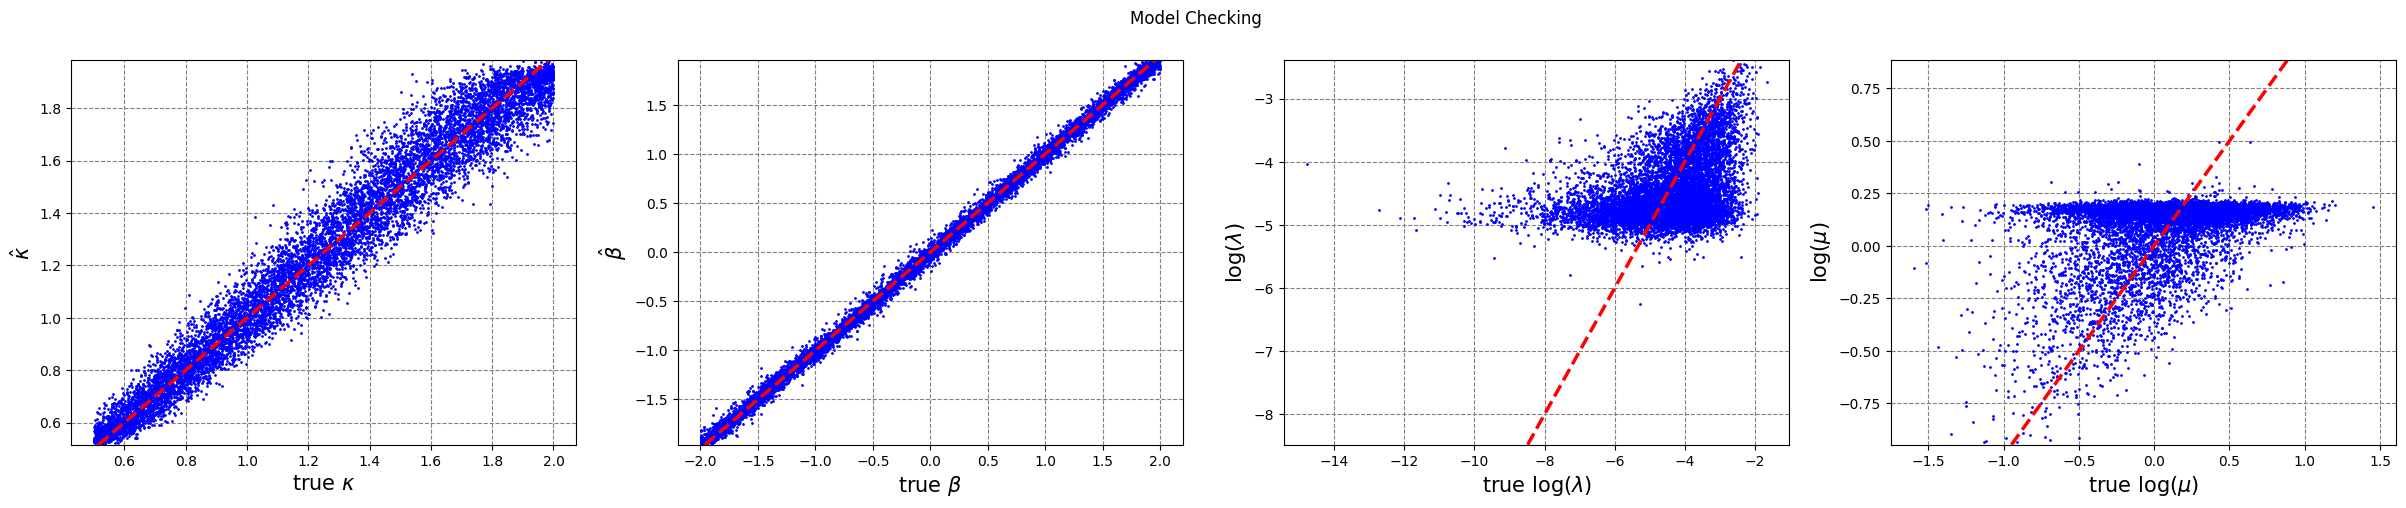

In [11]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$',  r'true log($\lambda$)', r'true log($\mu$)']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$',  r'log($\lambda$)', r'log($\mu$)']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()


fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])

plt.show()

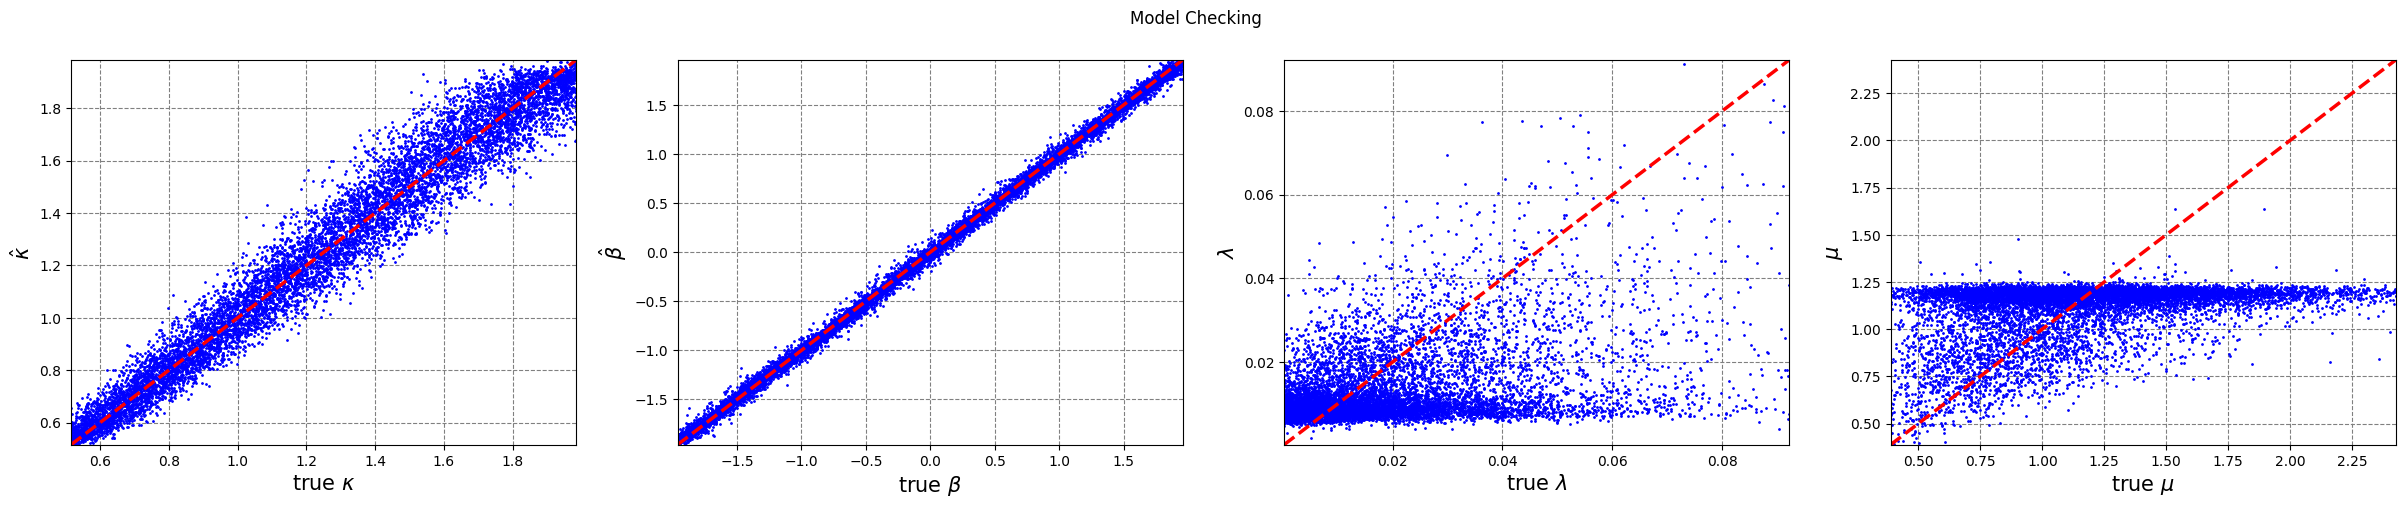

In [12]:
net.load_state_dict(torch.load(path))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

#true_name = [r'true $\beta$', r'true $log(\sigma)$', r'true $log(\lambda_p$)', r'true $log(\lambda_n)$', r'true $log(\eta_p)$', r'true $log(\eta_n)$']
true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

#esti_name = [r'$log(\hat{\beta})$', r'$log(\hat{\sigma})$', r'$log(\hat{\lambda_p})$', r'$log(\hat{\lambda_n})$', r'$log(\hat{\eta_p})$', r'$log(\hat{\eta_n})$']
esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\lambda$', r'$\mu$']


exp_ind = [2, 3]

with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

lim_left = torch.quantile(output,.01, 0).detach().cpu().numpy()
lim_right = torch.quantile(output,.99, 0).detach().cpu().numpy()

for i in exp_ind:
    lim_left[i] = np.exp(lim_left[i])
    lim_right[i] = np.exp(lim_right[i])
    

fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    if i in exp_ind:
        axes[i].scatter(torch.exp(y_test[:,i]), np.exp(tmp1), marker='o', color='b', s= 1)
    else:
        axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])
    axes[i].set_xlim([lim0, lim1])
    
plt.show()

In [13]:
torch.set_default_device("cpu")

df = pd.read_csv('X_G.txt', sep='\s+')
obs = torch.tensor(df.values)
obs = np.array(0)
obs = np.append(obs, df.values[:,1])
obs = torch.tensor(obs, dtype = torch.float32)
obs = torch.reshape(obs, (1, obs.size()[0]))

obs = MROUJ_summary(obs)

obs = torch.clone((obs - a) / (b - a))
net.eval()
print(net(obs))
print(torch.exp(net(obs)))

tensor([[ 1.0041,  0.1161, -3.1833, -0.3335]], grad_fn=<AddmmBackward0>)
tensor([[2.7294, 1.1231, 0.0414, 0.7164]], grad_fn=<ExpBackward0>)


In [14]:
path_cal = "./Comparison_sim/Comparison_sim"
X_cal = []
y_cal = []

sim_num = []
for j in range(2, 30):
    sim_num.append(j)

for j in sim_num:
    path_tmp = path_cal+str(j)+".pt"
    [tmp_X, tmp_y] = torch.load(path_tmp)
    X_cal.append(tmp_X)
    y_cal.append(tmp_y)

X_cal = torch.cat(X_cal, dim = 0)
y_cal = torch.cat(y_cal, dim = 0)

X_cal = torch.clone((X_cal - a) / (b - a))

output_cal = []
output_cal.append(y_cal[:,0])
output_cal.append(y_cal[:,1])
output_cal.append(torch.log(y_cal[:,2]))
output_cal.append(torch.log(y_cal[:,3]))
output_cal = torch.column_stack(output_cal)

In [24]:
net.eval()
results3 = conf_inf_sd(obs, X_cal, output_cal, net, .03)

train_loss: 0.207805  [   64/73500]
train_loss: 0.205327  [ 6464/73500]
train_loss: 0.169551  [12864/73500]
train_loss: 0.162851  [19264/73500]
train_loss: 0.163149  [25664/73500]
train_loss: 0.151303  [32064/73500]
train_loss: 0.149520  [38464/73500]
train_loss: 0.135966  [44864/73500]
train_loss: 0.119332  [51264/73500]
train_loss: 0.119275  [57664/73500]
train_loss: 0.115393  [64064/73500]
train_loss: 0.093012  [70464/73500]
Epoch 1
-------------------------------
train_loss 0.106182 val_loss 0.107368
Epoch 31
-------------------------------
train_loss 0.029140 val_loss 0.031208
train_loss: 0.025899  [   64/73500]
train_loss: 0.027677  [ 6464/73500]
train_loss: 0.024163  [12864/73500]
train_loss: 0.032029  [19264/73500]
train_loss: 0.035602  [25664/73500]
train_loss: 0.026919  [32064/73500]
train_loss: 0.032223  [38464/73500]
train_loss: 0.023113  [44864/73500]
train_loss: 0.027195  [51264/73500]
train_loss: 0.041368  [57664/73500]
train_loss: 0.029557  [64064/73500]
train_loss: 0.0

In [25]:
net.eval()
results4 = conf_inf_sd(obs, X_cal, output_cal, net, .04)

train_loss: 0.179687  [   64/98000]
train_loss: 0.162244  [ 6464/98000]
train_loss: 0.159999  [12864/98000]
train_loss: 0.171773  [19264/98000]
train_loss: 0.135182  [25664/98000]
train_loss: 0.121131  [32064/98000]
train_loss: 0.112009  [38464/98000]
train_loss: 0.123981  [44864/98000]
train_loss: 0.109402  [51264/98000]
train_loss: 0.103265  [57664/98000]
train_loss: 0.095651  [64064/98000]
train_loss: 0.085315  [70464/98000]
train_loss: 0.082141  [76864/98000]
train_loss: 0.068622  [83264/98000]
train_loss: 0.067568  [89664/98000]
train_loss: 0.077137  [96064/98000]
Epoch 1
-------------------------------
train_loss 0.070885 val_loss 0.070796
Epoch 31
-------------------------------
train_loss 0.024167 val_loss 0.024990
train_loss: 0.032167  [   64/98000]
train_loss: 0.020796  [ 6464/98000]
train_loss: 0.030567  [12864/98000]
train_loss: 0.025421  [19264/98000]
train_loss: 0.035942  [25664/98000]
train_loss: 0.029957  [32064/98000]
train_loss: 0.027778  [38464/98000]
train_loss: 0.0

In [26]:
results5 = conf_inf_sd(obs, X_cal, output_cal, net, .05)

train_loss: 0.190848  [   64/122499]
train_loss: 0.180714  [ 6464/122499]
train_loss: 0.185285  [12864/122499]
train_loss: 0.176199  [19264/122499]
train_loss: 0.162660  [25664/122499]
train_loss: 0.138476  [32064/122499]
train_loss: 0.130022  [38464/122499]
train_loss: 0.123148  [44864/122499]
train_loss: 0.117763  [51264/122499]
train_loss: 0.115776  [57664/122499]
train_loss: 0.098923  [64064/122499]
train_loss: 0.101890  [70464/122499]
train_loss: 0.091591  [76864/122499]
train_loss: 0.083352  [83264/122499]
train_loss: 0.087408  [89664/122499]
train_loss: 0.088686  [96064/122499]
train_loss: 0.078098  [102464/122499]
train_loss: 0.075381  [108864/122499]
train_loss: 0.064811  [115264/122499]
train_loss: 0.084347  [121664/122499]
Epoch 1
-------------------------------
train_loss 0.064705 val_loss 0.065139
Epoch 31
-------------------------------
train_loss 0.026017 val_loss 0.027135
train_loss: 0.025668  [   64/122499]
train_loss: 0.027274  [ 6464/122499]
train_loss: 0.032237  [12

In [15]:
#torch.save([results3, results4, results5], "results/Comparison_infer.pt")

In [16]:
true_param = [1, 0, 0.07, 1]
results_list = torch.load("./results/Comparison_infer.pt")

exp_ind = [2, 3]
size = 100000

sam = []
for j in range(len(true_param)):
    sam_1 = []
    for i in range(len(results_list)):
        results = results_list[i]
        samples_1 = []
        if j in exp_ind:
            samples_1.append(np.exp(results[1][:,j].detach().cpu().numpy()))
        else:
            samples_1.append(results[1][:,j].detach().cpu().numpy())
        vec = samples_1[0]
        
        np.random.seed(1)
        weights = np.copy(results[0].detach().cpu().numpy())
        P = weights/weights.sum()
        
        sam_2 = np.random.choice(vec,size,replace=True, p=P)
        sam_1.append(sam_2)
    sam.append(sam_1)

In [17]:
for j in range(len(true_param)):
    tmp = np.concatenate(sam[j])
    hpd_source = hpd_grid(tmp, 0.05, 5)
    print("interval: ",hpd_source[0], "mean: ", tmp.mean(), "med: ", np.median(tmp),
          "sd: ",tmp.std(), "mod: ", hpd_source[3])
    

/tmp/ipykernel_39852/1091780546.py:30: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(sample)


interval:  [(0.84234, 1.15873)] mean:  0.99903095 med:  0.99731326 sd:  0.08024714 mod:  [0.9952]
interval:  [(0.00648, 0.23467)] mean:  0.12247612 med:  0.12277156 sd:  0.057651173 mod:  [0.12783]
interval:  [(0.00131, 0.10467)] mean:  0.048582677 med:  0.04329325 sd:  0.030284792 mod:  [0.03533]
interval:  [(0.36179, 1.15544)] mean:  0.744043 med:  0.7262701 sd:  0.20494643 mod:  [0.69248]
